## Created on Mon June 24 2024

## @author: Jeong-Woon, Park

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'TMEM45B'),
  Text(1, 0, 'KCNJ11'),
  Text(2, 0, 'KRT5'),
  Text(3, 0, 'CDH3'),
  Text(4, 0, 'MAPT'),
  Text(5, 0, 'TYMS'),
  Text(6, 0, 'MYBL2'),
  Text(7, 0, 'FAM83D'),
  Text(8, 0, 'ESR1'),
  Text(9, 0, 'FOXC1'),
  Text(10, 0, 'NAT1'),
  Text(11, 0, 'SFRP1')])

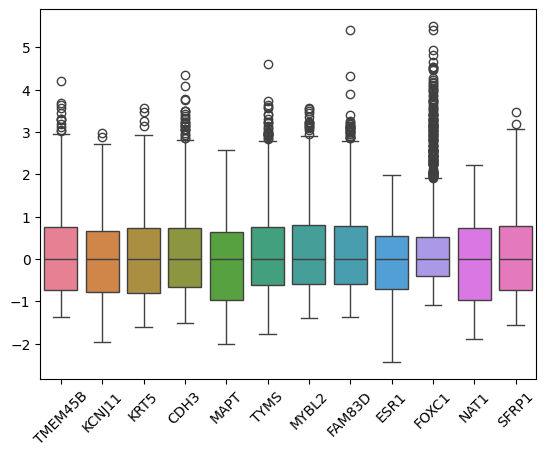

In [2]:
# Load X_train gene expression dataset.
X_train = pd.read_csv("/home/wjddns037/Code/Project_code/X_train_feature_select.csv", sep = "\t")
X_train.index = X_train.loc[:, "Unnamed: 0"].tolist()
X_train = X_train.drop(columns = ["Unnamed: 0"])

# Feature distritubion after normalization (Train)
plt.rcdefaults()
sns.boxplot(X_train)
plt.xticks(rotation = 45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'TMEM45B'),
  Text(1, 0, 'KCNJ11'),
  Text(2, 0, 'KRT5'),
  Text(3, 0, 'CDH3'),
  Text(4, 0, 'MAPT'),
  Text(5, 0, 'TYMS'),
  Text(6, 0, 'MYBL2'),
  Text(7, 0, 'FAM83D'),
  Text(8, 0, 'ESR1'),
  Text(9, 0, 'FOXC1'),
  Text(10, 0, 'NAT1'),
  Text(11, 0, 'SFRP1')])

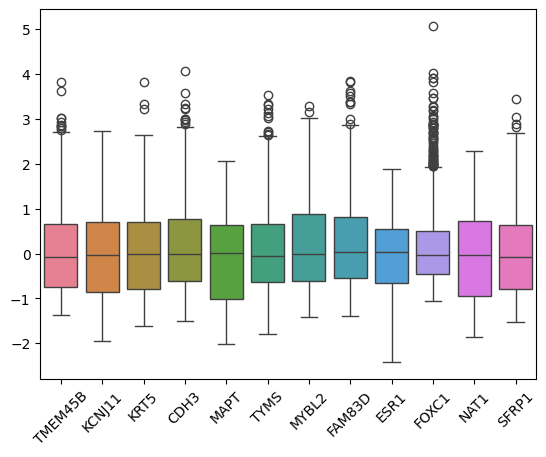

In [3]:
# Load X_test gene expression dataset.
X_test = pd.read_csv("/home/wjddns037/Code/Project_code/X_test_feature_select.csv", sep = "\t")
X_test.index = X_test.loc[:, "Unnamed: 0"].tolist()
X_test = X_test.drop(columns = ["Unnamed: 0"])

# Feature distritubion after normalization (Test)
plt.rcdefaults()
sns.boxplot(X_test)
plt.xticks(rotation = 45)

In [4]:
# Load PAM50 subtype dataset.
target = pd.read_csv("/home/wjddns037/Code/Project_code/GPL11154_PAM50.csv", sep = "\t")
target.index = target.loc[:, "Unnamed: 0"].tolist()
target = target.drop(columns = ["Unnamed: 0"])
target.head()

,BRCA_Subtype_PAM50
GSM2528079,Basal
GSM2528080,LumA
GSM2528081,LumB
GSM2528082,LumA
GSM2528084,Basal


In [5]:
# Load test PAM50 subtype dataset.
y_train = target.loc[X_train.index.tolist(), :]
y_train.head()

,BRCA_Subtype_PAM50
GSM2528830,Her2
GSM2530511,LumA
GSM2529478,LumA
GSM2528452,LumA
GSM2531266,LumB


In [6]:
# Load test PAM50 subtype dataset.
y_test = target.loc[X_test.index.tolist(), :]
y_test.head()

,BRCA_Subtype_PAM50
GSM2530931,LumB
GSM2528314,Basal
GSM2528222,Basal
GSM2531033,LumA
GSM2529552,LumB


In [7]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [8]:
# Downsampling based on k-means cluster,
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state = 42)
X_res, y_res = cc.fit_resample(X_train, y_train)

Text(0, 0.5, 'Frequency')

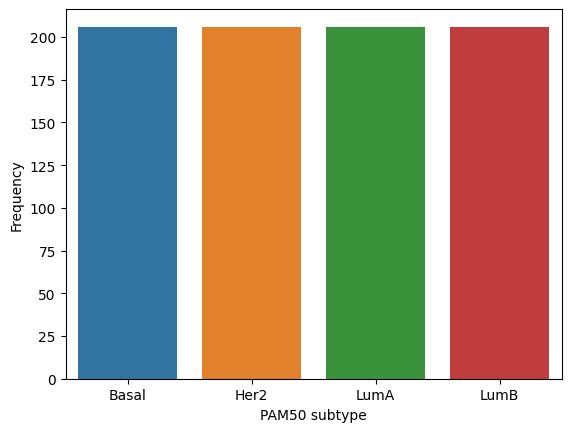

In [9]:
# Check count for each class in the training data.
class_counts = pd.Series(y_res).groupby(y_res).size()
class_counts.index = ["Basal", "Her2", "LumA", "LumB"]
sns.barplot(x = class_counts.index, y = class_counts.values, hue = class_counts.index)
plt.xlabel("PAM50 subtype")
plt.ylabel("Frequency")

### Hyperparameter tuning using GridSearchCV

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, roc_auc_score, make_scorer, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve
from imblearn.metrics import specificity_score, sensitivity_score

# Perfome grid search with 10-fold stratified cross-validation.
hyperparameters = {'C' : [0.001, 0.01, 0.1, 1]}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 123)
specificity = make_scorer(specificity_score, average = "macro")
sensitivity = make_scorer(sensitivity_score, average = "macro")

scoring = {"accuracy" : "accuracy",
           "specificity" : specificity,
           "sensitivity" : sensitivity,
           "f1-score" : "f1_macro",
           "auc" : "roc_auc_ovr"}

clf = SVC(random_state = 42, probability = True, kernel = "linear")
optimizer = GridSearchCV(clf, hyperparameters, cv = cv, scoring = scoring, 
                         n_jobs = 60, return_train_score = True, refit = "accuracy")
best_model = optimizer.fit(X_res, y_res)

In [11]:
print('가장 좋은 C 값:', best_model.best_estimator_.get_params()['C'])
print("가장 좋은 Score :", best_model.best_score_)

가장 좋은 C 값: 1
가장 좋은 Score : 0.904263884807523


In [12]:
# Make GridSearCV result.
CV_result = pd.DataFrame(best_model.cv_results_)
select_columns = ['params',
                  'mean_train_accuracy', 'std_train_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
                  'mean_train_specificity', 'std_train_specificity', 'mean_test_specificity', 'std_test_specificity',
                  'mean_train_sensitivity', 'std_train_sensitivity', 'mean_test_sensitivity', 'std_test_sensitivity',
                  'mean_train_f1-score', 'std_train_f1-score', 'mean_test_f1-score', 'std_test_f1-score',
                  'mean_train_auc', 'std_train_auc', 'mean_test_auc', 'std_test_auc']

Final_GRID_result = CV_result.loc[:, select_columns].sort_values(by = 'mean_test_accuracy', ascending = False).reset_index(drop = True).transpose()
Final_GRID_result

,0,1,2,3
params,{'C': 1},{'C': 0.1},{'C': 0.01},{'C': 0.001}
mean_train_accuracy,0.92914,0.922613,0.905313,0.871291
std_train_accuracy,0.004705,0.004137,0.004416,0.00472
mean_test_accuracy,0.904264,0.90365,0.8949,0.864562
std_test_accuracy,0.030663,0.029073,0.028778,0.032136
mean_train_specificity,0.97638,0.974204,0.968438,0.957095
std_train_specificity,0.001568,0.001379,0.001472,0.001576
mean_test_specificity,0.968081,0.967881,0.964959,0.954865
std_test_specificity,0.010218,0.009685,0.009606,0.01072
mean_train_sensitivity,0.929141,0.922614,0.905313,0.87128


### Model evaluation using hyperparameter

In [13]:
# Model fitting and prediction.
model = best_model.best_estimator_
model.fit(X_res, y_res)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [14]:
# Classification report
print(classification_report(y_test, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       0.92      0.92      0.92        92
        Her2       0.78      0.89      0.83        89
        LumA       0.96      0.91      0.94       450
        LumB       0.83      0.89      0.86       200

    accuracy                           0.90       831
   macro avg       0.87      0.90      0.89       831
weighted avg       0.91      0.90      0.90       831



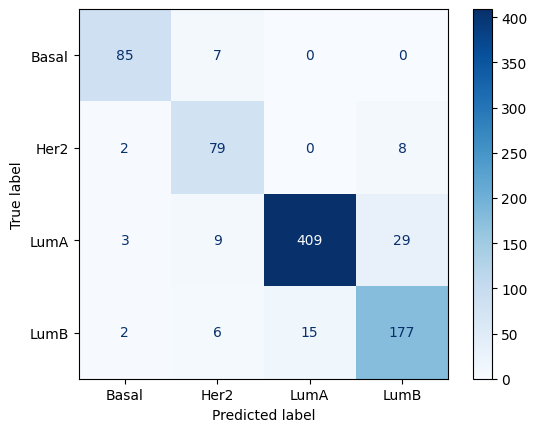

In [15]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues, normalize = None)
plt.grid(False)
plt.show()

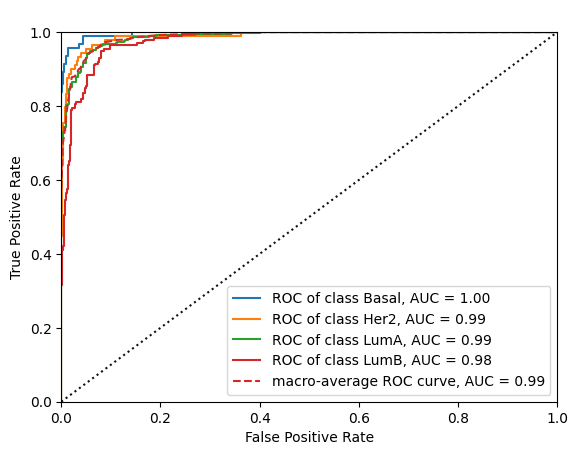

<Axes: title={'center': ' '}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [16]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], 
                    macro = True, micro = False, title = " ")

visualizer.fit(X_res, y_res)        
visualizer.score(X_test, y_test)
visualizer.show()

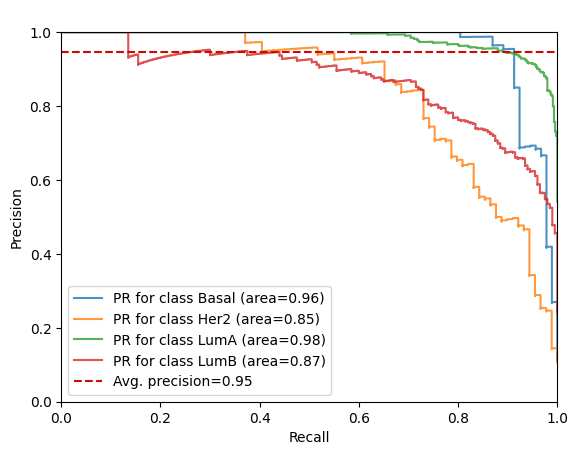

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [17]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, per_class = True, classes = ["Basal", "Her2", "LumA", "LumB"], title = " ")
visualizer.fit(X_res, y_res) 
visualizer.score(X_test, y_test)       
visualizer.show()

In [18]:
# Accuracy
accuracy_score(y_test, y_pred)

0.9025270758122743

In [19]:
# Macro average specificity
specificity_score(y_test, y_pred, average = "macro")

0.9657177454420738

In [20]:
# Macro average sensitivity
sensitivity_score(y_test, y_pred, average = "macro")

0.901360595451338

In [21]:
# Macro F1 score
f1_score(y_test, y_pred, average = "macro")

0.8866228070175439

In [22]:
# Macro average AUROC
roc_auc_score(y_test, y_pred_proba, multi_class = "ovr", average = "macro")

0.9875723232891238